In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import multianalysis as ma
import metabolinks.transformations as transf
import netlsd as nl
import itertools

# Formula Networks using Cytoscape Plugin MetaNetter

This notebook will cover the explorative studies into making networks from a list of masses. Each m/z will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite. It is somewhat similar to what was obtained with formulas assigned.


## 2 analysis:

### 1 - NetTF - Using the transformation list created here with the transformations mentioned and described in Formula_Networks.

PS: I need better descriptions and justifications of them - total of 16.

### 2 - NetMN - Using the transformation list default to the plugin MetaNetter but only considering most of the small groups/transformations (until a max of 80 m/z).

- Only took out Arginine, Arg to Ornitine (aminoacid related) and pyrophosphate (PP).
- Left 30 different groups - almost double from our original list, more edges expected in the resulting networks.
- Most of our 16 transformation list is in this list with some exceptions (S, CHOH, OH (that I don't have a good justification to leave in) and NCH), some differences (different de-amination). One different group is noteworthy - carbamoylatransferase - where only one can be correct (CONH in our list versus CONH2 in theirs).

MetaNetter papers:

- MetaNetter - https://academic.oup.com/bioinformatics/article/24/1/143/205461 (2nd author is the 1st author of the original MDiNs paper)
- MetaNetter 2.0 - https://pubmed.ncbi.nlm.nih.gov/29030098/

### Reading the files to make the list of masses that will be used in Cytoscape to make the network 

#### Reading Yeast dataset

Most of this was taken from the yeast_new notebook.

File and formulas given by the MetaboScape software.

In [2]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    data = data.sort_values(by = 'm/z')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    # peak_cols = ['m/z', 'Name', 'Formula']
    # intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    # peaks = data[peak_cols]
    # intensities = data[intensity_cols]

    # replace zeros for NaN's
    #intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    #peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        data = mtl.add_labels(data, labels=add_labels)
    
    return data

In [3]:
def renamer(colname):
    # Useful to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da'

labels = 'Metadata BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

In [4]:
# Read in the two files and keep results in dicts 
prefix_to_drop = None # change to 'ENO' to remove ENO strain

yeast_data = reading_MetScape_file('5yeasts_notnorm_2.csv', 
                                       remove_ref_feat=None,
                                       add_labels=None,
                                       col_renamer=renamer,
                                       prefix_to_drop=None)
yeast_data

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,3945019.75,3852594.00,3821208.250,4.204017e+06,4131124.25,4.059027e+06,4.352161e+06,4440771.000,4499343.500,4.345543e+06,4.091804e+06,4.545699e+06,4.248517e+06,4.207834e+06,4.208490e+06
201.1729328725 Da,202.18021,NaN,C11H23NO2,3404298.50,3366785.00,3348790.750,3.672346e+06,3737722.00,3.793184e+06,3.923927e+06,3804580.500,3801558.250,3.835366e+06,3.708862e+06,3.889770e+06,3.635306e+06,3.618243e+06,3.543283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


feature_filter function is used to join different features that share the same formula by adding all of the intensity in each sample for each of those features. The exact m/z that remains corresponds to the feature that contributes the most to the full intensity of the different features that share the formula.

In [5]:
def feature_filter(Spectra):
    """Join all features that share the same formula by simple addition.
       
       Spectra: AlignedSpectra object (from metabolinks).
       
       Returns: Aligned Spectra object (from metabolinks) with filtered dataset.
    """
    df = Spectra
    #Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    #Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: #If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else:
            if form_count[i] > 1: #If the formula appears more than one time in the dataset
                if i not in rep: #And If it didn't already appear before
                    #Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    #same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:3]
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 0) #Addition of all m/z peaks intensity
                    newrow_c = pd.concat([info, newrow], axis = 0)
                    #m/z peak stays is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    #Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) #Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else:
                rp = rp.append(df.iloc[a,:]) #Append peaks with formulas that aren't repeated in the dataset
        a = a + 1
    #return dataframe in AlignedSpectra format.
    return rp

In [6]:
#Joining rows that have the same formula assigned (with feature_filter) while keeping rows without formulas assigned.
yeast_df = feature_filter(yeast_data)
yeast_df

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,6.566536e+05,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,7349318.25,7219379.00,7169999.000,7.876362e+06,7868846.25,7.852211e+06,8.276088e+06,8245351.500,8.300902e+06,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.1749731669 Da,202.18225,NaN,NaN,1317428.75,1552194.75,1605307.875,1.035239e+06,965660.50,8.913902e+05,7.434838e+05,693080.750,5.866896e+05,1.057169e+06,1.070222e+06,1.089031e+06,1.583372e+06,1.482374e+06,1.570275e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2997.0704767576 Da,2998.07775,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,6.362384e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [7]:
#Only keeping features that appear in at least 2 samples
yeast_df_temp = transf.keep_atleast(yeast_df.iloc[:,3:].replace({0:np.nan}), min_samples=2)
yeast_df = yeast_df.loc[yeast_df_temp.index]

#Changing the index to be numbers - our list of NEUTRAL masses from the bucket lists.
new_index = []
for i in range(len(yeast_df)):
    new_index.append(np.float(yeast_df.index[i][:-3]))
yeast_df.index = new_index

#Only keep peaks below 1000 m/z
yeast_df = yeast_df[yeast_df.iloc[:,0] < 1000]

yeast_df

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.177576,201.18485,Butyl octanoate,C12H24O2,0.000000e+00,0.00,0.000000e+00,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,6.101359e+05,6.566536e+05,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.293023,201.30030,NaN,NaN,1.238711e+06,1275006.75,1.283942e+06,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.172770,202.18005,NaN,C11H23NO2,7.349318e+06,7219379.00,7.169999e+06,7.876362e+06,7868846.25,7.852211e+06,8.276088e+06,8.245352e+06,8.300902e+06,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.174973,202.18225,NaN,NaN,1.317429e+06,1552194.75,1.605308e+06,1.035239e+06,965660.50,8.913902e+05,7.434838e+05,6.930808e+05,5.866896e+05,1.057169e+06,1.070222e+06,1.089031e+06,1.583372e+06,1.482374e+06,1.570275e+06
201.979104,202.98638,NaN,C4H10O3S3,5.979574e+05,0.00,5.714457e+05,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937.130478,938.13775,NaN,NaN,0.000000e+00,885170.25,0.000000e+00,8.065278e+05,0.00,0.000000e+00,6.682040e+05,6.535156e+05,5.383812e+05,7.251112e+05,9.439709e+05,9.694091e+05,0.000000e+00,0.000000e+00,7.182504e+05
938.127853,939.13513,NaN,C27H38N16O10S6,6.270084e+05,0.00,8.009592e+05,0.000000e+00,575956.25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.376864e+05,0.000000e+00
985.320748,986.32802,NaN,C51H57NO15P2,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,6.712075e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.547402e+05,0.000000e+00
986.685387,987.69266,NaN,C39H98N14O8S3,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,6.051672e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.263648e+05,0.000000e+00


## Building the full network for the full Yeast dataset in Cytoscape

To build the network in Cytoscape we'll need:

1) A list of masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences (that will be in one case ours, and in the other case from the default MetaNetter list as explained).

The network built in Cytoscape had a 1 ppm error allowed for edge establishment. Discussions on the format the network built is done later. Also, only one full network (in each case is done) and then subgraphs of it will be used for every sample instead of building one for each sample (also explained later).

### Writing a .csv file with a list of masses that is able to be correctly read by Cytoscape's MetaNetter (and Cytoscape) where the network will be built

The list of masses in a .csv file. Two columns with the list of masses (one index, one in the column) for one to be the node name as a 'string' and the other node attribute as a 'float'.

In [8]:
pd.DataFrame(yeast_df.index, index=yeast_df.index).to_csv('MassList_YD.csv')

### Making the transformation file

This file will be in a format accepted by Cytoscape's MetaNetter (.txt separated by tabs) to be considered as a list of transformations (with specific masses) to make the MDiN. 4 columns: 'Label','Formula','Mass','Selected' with mass being the most important.

Since Label is the 2nd most important since the existence of the transformation attribute of each edge (important for group_influence calculated), I'll put the formula changes in label and reactions that describe functions in formula, since formula changes are more quickly understood and are more concise.

In [9]:
#Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances - https://ciaaw.org/isotopic-abundances.htm / https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
#isotoptic abundances from Pure Appl. Chem. 2016; 88(3): 293–306, Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503
#electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078)} 

Functions to transform formulas in string format to dictionary format and from this to calculate formulas exact masses

In [10]:
def formula_process(formula):
    """Transforms a formula in string format into a dictionary."""
    
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    #Empty dictionary to store the results
    results = dict.fromkeys(['C','H','O','N','S','P','Cl','F'], 0)
    count = ''
    letter = None
    
    #Run through the string
    for i in range(len(formula)):
        if formula[i].isupper(): #If i is an uppercase letter then it is an element
            if letter: #Just to account for the first letter in the formula where letter is None
                results[letter] = int(count or 1) #Reached another letter, store previous results and reset count
                count = ''
                
            if i+1 < len(formula): #In case it's a two letter element such as Cl
                if formula[i+1].islower(): #The second letter is always lower case
                    letter = formula[i] + formula[i+1] #Store new 2 letter element
                    continue
                    
            letter = formula[i] #Store new 1 letter element
            
        elif formula[i].isdigit():
            count = count + formula[i] #If number, add number to count
    
    #Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

In [11]:
def getmass(c,h,o,n,s,p,cl,f):
    "Get the exact mass for any formula."
    massC = chemdict['C'][0] * c
    massH = chemdict['H'][0] * h
    massO = chemdict['O'][0] * o
    massN = chemdict['N'][0] * n
    massS = chemdict['S'][0] * s
    massP = chemdict['P'][0] * p
    massCl = chemdict['Cl'][0] * cl
    massF = chemdict['F'][0] * f 

    massTotal = massC + massH + massO + massN + massS + massP + massCl + massF

    return massTotal

Making the transformation file

In [12]:
#Prepare DataFrame
trans_groups = pd.DataFrame(columns=['Label','Formula','Mass','Selected'])
trans_groups = trans_groups.set_index('Label')

#Group Formula changes
groups = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
#Reactions responsible for their respective group changes
labels = ['Hydrogenation','Methylation','Carboxylation/Decarboxylation','Oxygenation','Hydroxymethylation',
          'Formidoylation','Deamination','Hydroxylation','S','Carbamoylation','Phosphorylation','Transamination',
          'Sulphation','Formylation','Acetylation','Condensation/Dehydration']

for i in range(len(groups)): #Passing through each transformation/group
    #Calculate the exact mass of the groups
    a = formula_process(groups[i])
    group_mass = getmass(a['C'],a['H'],a['O'],a['N'],a['S'],a['P'],a['Cl'],a['F'])
    
    #Groups with removed things have to be done manually
    if groups[i] == 'O(-NH)':
        group_mass = getmass(a['C'],-1,a['O'],-1,a['S'],a['P'],a['Cl'],a['F'])
    elif groups[i] == 'NH3(-O)':
        group_mass = getmass(a['C'],a['H'],-1,a['N'],a['S'],a['P'],a['Cl'],a['F'])
        
    #Making the row for each transformation
    string = groups[i]
    trans_groups.loc[string] = (labels[i], group_mass, 'true')
#print(trans_groups)

trans_groups = trans_groups.sort_values(by='Mass')
trans_groups

,Formula,Mass,Selected
Label,,,
O(-NH),Deamination,0.984016,true
NH3(-O),Transamination,1.031634,true
H2,Hydrogenation,2.015650,true
CH2,Methylation,14.015650,true
O,Oxygenation,15.994915,true
OH,Hydroxylation,17.002740,true
H2O,Condensation/Dehydration,18.010565,true
NCH,Formidoylation,27.010899,true
CO,Formylation,27.994915,true


In [13]:
#Saving the df as a .txt file in the described format
trans_groups.to_csv('transgroups.txt', header=False, sep='\t')

## Reading the network obtained from Cytoscape after MDiN built from MetaNetter

The network was obtained in graphml format that networkX module can read. The networks aren't however in an ideal state.

- Nodes have a standard 'number' ID instead of the mass which is fortunately stored as the attribute 'mass'. Other attributes stored are irrelevant. In NetTF, I accidently let it store many attributes based on different statistical analysis which shouldn't be present.
- Edges among the different attributes have a very useful one called 'Transformation' which stores which group of the list was used to establish the edge.
- Finally, the graph is directed despite only having one connection between any two nodes. Since reactions are bidireccional, they will be transformed to undirected graphs. Below it is shown that the number of edges remains the same between the directed and undirected graph and that.

Changes that will be made to the network:

- Nodes will be identified by their masses.
- Intensities of the node in each sample will be given later to store for each specific subgraph.

### NetTF - Network made with our list of transformations

In [14]:
#Reading the network made
NetTF_dir = nx.read_graphml('Network-TF.graphml')
NetTF = NetTF_dir.to_undirected()

In [15]:
print(len(NetTF_dir.edges()),len(NetTF.edges()))
print(len(NetTF_dir.nodes()),len(NetTF.nodes()))

820 820
1893 1893


In [16]:
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(NetTF.nodes(),0)
formula_attr = dict.fromkeys(NetTF.nodes(),0)

for i,j in nx.get_node_attributes(NetTF,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
nx.set_node_attributes(NetTF,formula_attr)
NetTF = nx.relabel_nodes(NetTF, mapping=new_nodes)

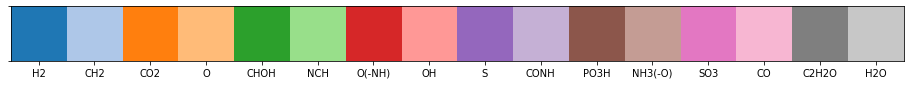

In [17]:
colours = sns.color_palette('tab20', 16)

unique_group = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
group_colors = {lbl: c for lbl, c in zip(unique_group, colours)}

sns.palplot(group_colors.values())
new_ticks = plt.xticks(range(len(unique_group)), unique_group)

edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(NetTF,'Transformation').values()]

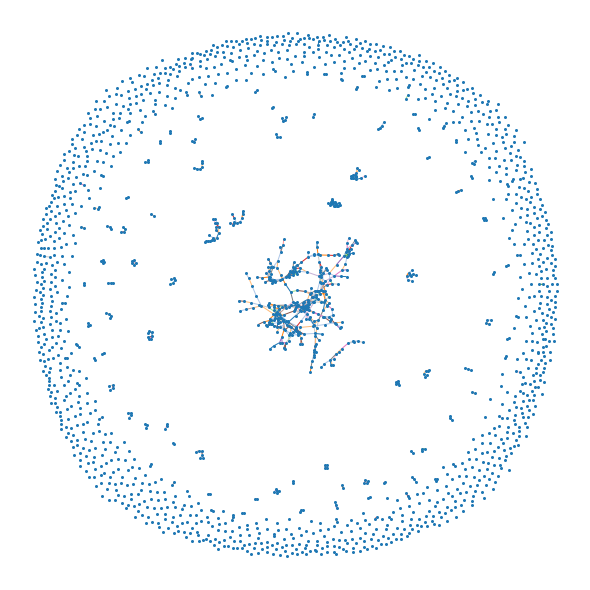

In [18]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NetTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [19]:
#Spread of components
[len(c) for c in sorted(nx.connected_components(NetTF), key=len, reverse=True)][:20]

[276, 18, 17, 16, 14, 14, 11, 9, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4]

#### Full Yeast Dataset Network Analysis with out transformation list (analysis that will be done for each individual sample network)

Group Influence calculation (H2, CH2, O, CO and H20 with a high group influences)

In [20]:
#Group Influence in building the network
NetTF_groups = dict.fromkeys(groups, 0) #groups from the transformation list
for i in NetTF.edges():
    NetTF_groups[NetTF.edges()[i]['Transformation']] = NetTF_groups[NetTF.edges()[i]['Transformation']] + 1

NetTF_groups

{'H2': 101,
 'CH2': 152,
 'CO2': 39,
 'O': 100,
 'CHOH': 6,
 'NCH': 27,
 'O(-NH)': 38,
 'OH': 10,
 'S': 13,
 'CONH': 19,
 'PO3H': 36,
 'NH3(-O)': 32,
 'SO3': 11,
 'CO': 78,
 'C2H2O': 62,
 'H2O': 96}

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [21]:
#nx.degree(Gr)
NetTF_degree = dict(NetTF.degree())
NetTF_degree_all = sorted(NetTF_degree.items(), key=lambda kv: kv[1], reverse = True)
NetTF_degree_all[:20]

[(298.2508367981, 10),
 (299.282447629, 9),
 (283.2875497027, 9),
 (282.2558879557, 9),
 (399.3348641583, 8),
 (284.2351682088, 8),
 (270.2559171241, 8),
 (270.2195089685, 8),
 (268.2401689019, 8),
 (256.2402073027, 8),
 (254.2246098628, 8),
 (369.3242846161, 7),
 (383.3399300087, 7),
 (328.2613558341, 7),
 (356.1237549523, 7),
 (355.3450176173, 7),
 (353.3293339397, 7),
 (314.2456395099, 7),
 (340.1288250279, 7),
 (337.0943779384, 7)]

In [22]:
NetTF_betw = nx.betweenness_centrality(NetTF)
NetTF_betw_all = sorted(NetTF_betw.items(), key=lambda kv: kv[1], reverse = True)
NetTF_betw_all[:20]

[(340.2016151107, 0.009794002130137881),
 (338.185930009, 0.00969653739813493),
 (382.175747131, 0.009651816829020967),
 (398.1706129689, 0.009608307441987174),
 (384.1550071491, 0.00877353176385747),
 (382.2121031609, 0.008346910505289979),
 (340.1288250279, 0.008318207415153905),
 (382.139364127, 0.008246638328512449),
 (312.0975382871, 0.007115597073685622),
 (326.1131891847, 0.007041434945324386),
 (302.2457548807, 0.0061262208537926945),
 (203.115666118, 0.005035522772538994),
 (246.121610768, 0.004984237862744374),
 (217.1314940618, 0.004823072118891978),
 (270.0868945993, 0.004112814026298443),
 (284.271563201, 0.003380409620680956),
 (289.1274004049, 0.0030870981530777618),
 (284.2351682088, 0.0029368250898689266),
 (298.0818853463, 0.0027758565235659932),
 (411.2385824393, 0.0026193897910650084)]

In [23]:
NetTF_closeness = nx.closeness_centrality(NetTF)
NetTF_closeness_all = sorted(NetTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
NetTF_closeness_all[:20]

[(382.2121031609, 0.01706700693106667),
 (302.2457548807, 0.01704517280706104),
 (284.2351682088, 0.0167804073184543),
 (286.2508146507, 0.01673123910948436),
 (340.2016151107, 0.016654554263565893),
 (298.2508367981, 0.016421910531042788),
 (270.2559171241, 0.016394967281607113),
 (314.2456395099, 0.016241743288321064),
 (328.2613558341, 0.016189117145629057),
 (338.185930009, 0.01613031889933743),
 (256.2402073027, 0.01610432322020876),
 (410.2070680253, 0.016039699130240025),
 (326.2457281046, 0.015994770001023666),
 (274.2508139987, 0.015981979301302737),
 (268.2401689019, 0.015981979301302737),
 (271.2511819056, 0.015755195204003997),
 (299.282447629, 0.015718022112685075),
 (284.271563201, 0.015711843644873484),
 (242.2245493667, 0.015674874601003193),
 (367.2125092496, 0.015631963329119335)]

Heat Analysis - See the the diffusion of heat according to the package netlsd (nl) and plot the graph.

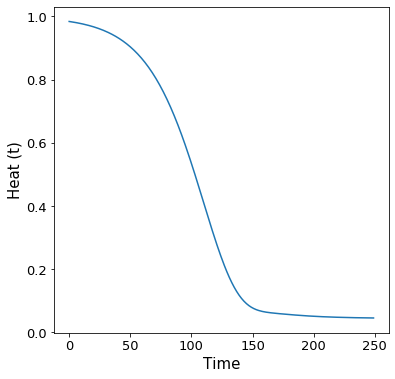

In [24]:
NetTF_heat = nl.heat(NetTF)

f, ax = plt.subplots(figsize=(6,6))
plt.plot(NetTF_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [25]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the netwrok is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times. Maybe should put more comments throughout the function
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} #To store results

    for i in GG.nodes():

        node_orbits[i] = {} #To store results
        orbits = node_orbits[i]

        ##size of comp
        #comp = len(nx.node_connected_component(GG, 'c'))

        #2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        #3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        #orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        #orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common)
            n_orb = n_orb + len(neigh_neigh)


            #orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3))
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        #orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 #always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                #print(neigh_neigh_neigh)

            #orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        #orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                #orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        #4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        #orbit 4
        orbits['4'] = n_orb4

        #orbit 5
        orbits['5'] = n_orb5

        #orbit 6
        orbits['6'] = n_orb6

        #orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        #orbit 8
        orbits['8'] = int(n_orb8)

        #orbit 9
        orbits['9'] = n_orb9

        #orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        #orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [26]:
NetTF_GCD = calculating_orbits(NetTF)
NetTF_GCD_df = pd.DataFrame.from_dict(NetTF_GCD).T
NetTF_CorrMat = stats.spearmanr(NetTF_GCD_df,axis=0)[0]

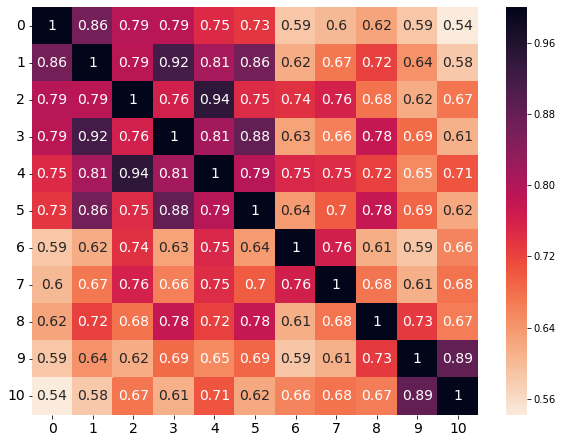

In [27]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NetTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### NetMN (MetaNetter) - Network made with MetaNetter's list of transformations

In [28]:
#Reading the network
NetMN_dir = nx.read_graphml('Network-MN.graphml')
NetMN = NetMN_dir.to_undirected()

In [29]:
print(len(NetMN_dir.edges()),len(NetMN.edges()))
print(len(NetMN_dir.nodes()),len(NetMN.nodes()))

1215 1215
1893 1893


In [30]:
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(NetMN.nodes(),0)
formula_attr = dict.fromkeys(NetMN.nodes(),0)

for i,j in nx.get_node_attributes(NetMN,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
nx.set_node_attributes(NetMN,formula_attr)
NetMN = nx.relabel_nodes(NetMN, mapping=new_nodes)

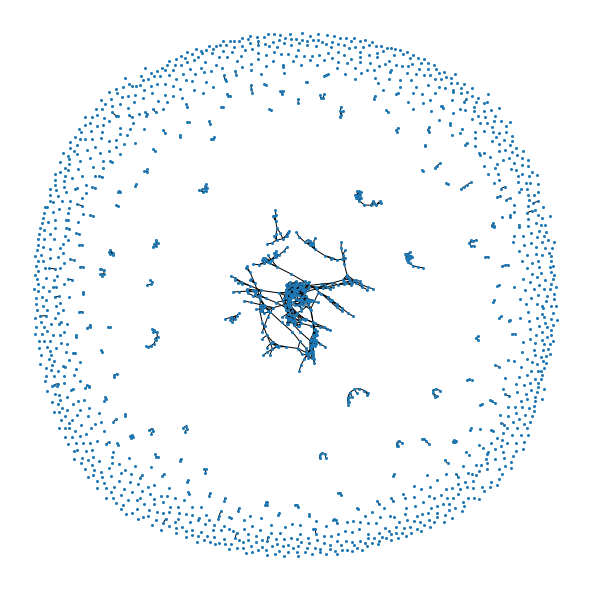

In [31]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NetMN, node_size=4, width = 1)#, edge_color=edge_colors)
plt.show()

In [32]:
#Spread of components
[len(c) for c in sorted(nx.connected_components(NetMN), key=len, reverse=True)][:20]

[307, 21, 20, 20, 19, 17, 17, 13, 12, 8, 8, 6, 6, 6, 6, 5, 5, 5, 5, 4]

#### Full Yeast Dataset Network Analysis with MN transformation list (analysis that will be done for each individual sample network)

In [33]:
#Group Influence in building the network
NetMN_groups = dict.fromkeys(set(nx.get_edge_attributes(NetMN, 'Transformation').values()), 0)
for i in NetMN.edges():
    NetMN_groups[NetMN.edges()[i]['Transformation']] = NetMN_groups[NetMN.edges()[i]['Transformation']] + 1

NetMN_groups

{'hydroxylation (-H)': 100,
 'methanol (-H2O)': 152,
 'primary amine': 9,
 'Ethanolamine (-H2O)': 3,
 'CO2H2': 53,
 'phosphate': 36,
 'acetone (-H)': 6,
 'Glycine': 29,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 133,
 'Acetyl CoA + H2O (-CoASH)': 46,
 'condensation/dehydration': 96,
 'C2H2': 79,
 'urea addition (-H)': 7,
 'PolyamineReactionA': 6,
 'acetylation (-H)': 6,
 'glyoxylate (-H2O)': 25,
 'hydrogenation/dehydrogenation': 101,
 'isoprene addition (-H)': 10,
 '"acetylation (-H2O), ketol group (-H2O)"': 62,
 'CHO2': 4,
 'Formic Acid (-H2O)': 78,
 'Inorganic Phosphate': 5,
 'carbamoyl P transfer (-H2PO4)': 4,
 'secondary amine': 26,
 'sulfate (-H2O)': 11,
 'tertiary amine': 17,
 'Mevalonate-5-pyrophosphate decarboxylase ': 14,
 'Polyamine Synthase': 26,
 'Carboxylation': 39,
 'Aminotransferase': 32}

In [34]:
#Group Influence in building the network
NetTF_groups = dict.fromkeys(groups, 0) #groups from the transformation list
for i in NetTF.edges():
    NetTF_groups[NetTF.edges()[i]['Transformation']] = NetTF_groups[NetTF.edges()[i]['Transformation']] + 1

NetTF_groups

{'H2': 101,
 'CH2': 152,
 'CO2': 39,
 'O': 100,
 'CHOH': 6,
 'NCH': 27,
 'O(-NH)': 38,
 'OH': 10,
 'S': 13,
 'CONH': 19,
 'PO3H': 36,
 'NH3(-O)': 32,
 'SO3': 11,
 'CO': 78,
 'C2H2O': 62,
 'H2O': 96}

#### Some notes:

- Most major groups that establish edges here are also present in our 16 list. However, some of those major groups aren't present.
- "Ethanol (-H2O), ethyl addition (-H2O)" establishes 133 edges and is the 2nd group with higher edge count below CH2 (152) and is not present.
- Other important groups not present are "acetylation (-H2O), ketol group (-H2O)" with 62 edges and 'C2H2' with 79 edges.

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [35]:
#nx.degree(Gr)
NetMN_degree = dict(NetMN.degree())
NetMN_degree_all = sorted(NetMN_degree.items(), key=lambda kv: kv[1], reverse = True)
NetMN_degree_all[:20]

[(327.3136893021, 13),
 (254.2246098628, 13),
 (399.3348641583, 12),
 (328.2613558341, 12),
 (299.282447629, 12),
 (283.2875497027, 12),
 (270.2559171241, 12),
 (268.2401689019, 12),
 (256.2402073027, 12),
 (242.2245493667, 12),
 (369.3242846161, 11),
 (356.1237549523, 11),
 (355.3450176173, 11),
 (298.2508367981, 11),
 (282.2558879557, 11),
 (401.3504904426, 10),
 (383.3399300087, 10),
 (358.3083016352, 10),
 (353.3293339397, 10),
 (343.2358883298, 10)]

In [36]:
NetMN_betw = nx.betweenness_centrality(NetMN)
NetMN_betw_all = sorted(NetMN_betw.items(), key=lambda kv: kv[1], reverse = True)
NetMN_betw_all[:20]

[(382.175747131, 0.005595973969467472),
 (188.1047773826, 0.0055744509421303675),
 (356.1237549523, 0.005270312836359937),
 (268.0713226384, 0.005025907669045468),
 (333.2151434908, 0.004968395756989975),
 (276.1572942597, 0.0047973460464200285),
 (354.1444622407, 0.004687129149136859),
 (296.1026126414, 0.004475895803636645),
 (410.2070680253, 0.004361156035427214),
 (203.115666118, 0.004000189293329388),
 (382.2121031609, 0.0038225317240515133),
 (302.2457548807, 0.003617340601449766),
 (271.2147682667, 0.0032632174222324978),
 (187.1208269152, 0.002908104075199128),
 (264.2452587364, 0.0028444501640531718),
 (330.2770157386, 0.0027794710488613862),
 (243.1583476089, 0.0027547497902791645),
 (344.2021408518, 0.002673648917388882),
 (358.3083016352, 0.0026382757845763707),
 (422.3243176689, 0.0026348770958247816)]

In [37]:
NetMN_closeness = nx.closeness_centrality(NetMN)
NetMN_closeness_all = sorted(NetMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
NetMN_closeness_all[:20]

[(302.2457548807, 0.027571301536450207),
 (242.2245493667, 0.02754061561376078),
 (328.2613558341, 0.026911629286529702),
 (256.2402073027, 0.026882393404632332),
 (270.2559171241, 0.02682411179291497),
 (382.2121031609, 0.02678056615688751),
 (314.2456395099, 0.02675161419347466),
 (284.2351682088, 0.026536453757602208),
 (268.2401689019, 0.026536453757602208),
 (299.282447629, 0.026465500672688835),
 (271.2511819056, 0.02636680141605121),
 (315.2773514702, 0.026352761585691224),
 (214.1932519061, 0.026254899871579904),
 (240.208834892, 0.026143944140479727),
 (330.2770157386, 0.02603392228191905),
 (255.2562733462, 0.02603392228191905),
 (304.2249798203, 0.025992902446390822),
 (286.21434567, 0.02597925787817749),
 (254.2246098628, 0.02585709835837415),
 (228.2088971606, 0.02584359595714262)]

Heat Analysis - See the the diffusion of heat according to the package netlsd (nl) and plot the graph.

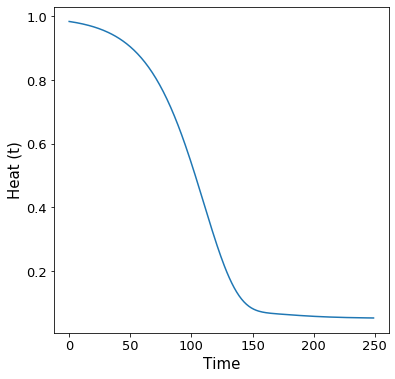

In [38]:
NetMN_heat = nl.heat(NetMN)

f, ax = plt.subplots(figsize=(6,6))
plt.plot(NetMN_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [39]:
NetMN_GCD = calculating_orbits(NetMN)
NetMN_GCD_df = pd.DataFrame.from_dict(NetMN_GCD).T
NetMN_CorrMat = stats.spearmanr(NetMN_GCD_df,axis=0)[0]

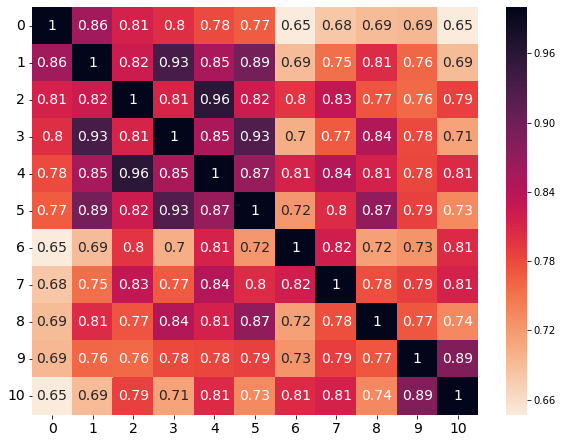

In [40]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NetMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### Fast Comparison between networks made with the two lists in terms of number of edges

In [41]:
print('NetTF edges:', len(NetTF.edges()), 'with 16 transformations.')
print('NetMN edges:', len(NetMN.edges()), 'with 30 transformations.')
print(len(NetMN.edges())/len(NetTF.edges())*100 - 100, '% more edges with almost double (100%) the number of groups.')

NetTF edges: 820 with 16 transformations.
NetMN edges: 1215 with 30 transformations.
48.17073170731706 % more edges with almost double (100%) the number of groups.


### Fast comparisons to original Formula_Networks

The original full yeast dataset network built in Formula_Networks had 1528 nodes with 665 edges. We can see that there is an increase in edge numbers with these methods that also have a lot more nodes since they consider m/z and not formulas, however that increase is not that substantial. Furthermore, the more important part of the networks - the main components, which are much bigger than any others, are all very similar in size, 263 in the original to 276 in TF and 307 in MN. 

With this similarity in the main component, we expect for both approaches to give similar results.

#### Some notes:

- Most major groups that establish edges here are also present in our 16 list. However, some of those major groups aren't present.
- "Ethanol (-H2O), ethyl addition (-H2O)" establishes 133 edges and is the 2nd group with higher edge count below CH2 (152) and is not present.
- Other important groups not present are "acetylation (-H2O), ketol group (-H2O)" with 62 edges and 'C2H2' with 79 edges.

##### Maybe these groups should be considered to be added in.

## Network consistency for formulas

This is basically to see if while propagating the formulas already assigned with the MetaboScape, the different connections of the network built by MetaNetter had internal consistency. That is, if we start with two different formulas assigned present in the same network component, all the nodes of that component would have the same formula whether it was propagated through one of the formulas assigned nodes or the other.

As we can see below, there wasn't a need to do an in-depth test of this since very early it became clear that this internal consistency could not be observed in these networks since:

1) Same formula on multiple nodes - the presence of very similar m/z made it so the same node used the same transformation to two different nodes (this was actually observed in the drawn network in Cytoscape).

2) Multiple formulas on multiple nodes depending on the starting formula - if we start assigning formulas based on two different nodes that had previously assigned formulas, some of these two nodes led to conflicting attributions for the nodes in the same component.

Only a short test was needed to reach this conclusion that is explained after some needed functions here.


#### Some functions needed from other notebooks to ease the analysis - deformulator (to turn string format formulas datasets into dataframe format formulas) and formulator (to turn dataframe format formulas into string format formulas).

In [42]:
def deformulator(df):
    """Transforms a set of formulas in string format into a DataFrame with columns corresponding to each element.
       Element order: Order of the elements in the formulas.
    """
    
    filtered_formulas = df['Formula'].dropna() #Dropping empty cells (without formulas)
    
    formula = {}
    for i in filtered_formulas:
        if 'C(13)' in i:
            #Ignores C(13) formulas - the C12 formulas already exist
            continue
        else:
            #Transform the string representing the formula into a dictionary and store all results in a dictionary
            formula[i] = formula_process(i)
            #formulas.loc[filtered_formulas[filtered_formulas == i].index[0]] = formula_process(i).iloc[0]
            
    #Transforming the dictionary of dictionaries into the pretended dataframe
    formula_df = pd.DataFrame.from_dict(formula).T
    formula_df = formula_df.replace({np.nan:0}).astype(int) #Replace nan values when an element doesn't appear in a formula for 0
    
    return formula_df

#Adapted from FTMSVisualization
def formulator(c,h,o,n,s,p,f=0,cl=0,c13=0):
    """Transforms element counts to a readable formula in string format. Element order: C, H, N, O, S, P, F, Cl (and C(13))."""
    
    formula = "C"+str(c)+"H"+str(h)

    if cl > 0:
        if cl > 1:
            formula = formula + "Cl" + str(cl)
        else:
            formula = formula + "Cl"
    if f > 0:
        if f > 1:
            formula = formula + "F" + str(f)
        else:
            formula = formula + "F"
    if n > 0:
        if n > 1:
            formula = formula + "N" + str(n)
        else:
            formula = formula + "N"
    if o > 0:
        if o > 1:
            formula = formula + "O" + str(o)
        else:
            formula = formula + "O"
    if p > 0:
        if p > 1:
            formula = formula + "P" + str(p)
        else:
            formula = formula + "P"
    if s > 0:
        if s > 1:
            formula = formula + "S" + str(s)
        else:
            formula = formula + "S"
    if c13 > 0:
        if c13 > 1:
            formula = formula + "C(13)" + str(s)
        else:
            formula = formula + "C(13)"
            
    return formula

#### Short test

1) Take only the nodes/masses with the most "reliable" formulas, that is, formulas that have a "Name" associated in the yeast dataset that were in theory annotated.

2) Assign formulas only to the direct neighbors (not the entire component) of those nodes based on the transformation attribute of the edge that links them.

3) See the formulas that were assigned to the different nodes by this method.

This was done only for the TF network since it was easier and its conclucions can be extrapolated to the MN dataset.

In [43]:
# Making the dataframe formulas dataset for the yeast dataset
formulas_df = deformulator(yeast_df)
formulas_df

,C,H,O,N,S,P,Cl,F
C12H24O2,12,24,2,0,0,0,0,0
C11H23NO2,11,23,2,1,0,0,0,0
C4H10O3S3,4,10,3,0,3,0,0,0
C9H17NO4,9,17,4,1,0,0,0,0
C8H17N3O3,8,17,3,3,0,0,0,0
...,...,...,...,...,...,...,...,...
C26H49O28PS3,26,49,28,0,3,1,0,0
C27H38N16O10S6,27,38,10,16,6,0,0,0
C51H57NO15P2,51,57,15,1,0,2,0,0
C39H98N14O8S3,39,98,8,14,3,0,0,0


In [44]:
# Making a dataframe formulas dataset of the trasnformations used to build the TF network
grouping_df = deformulator(pd.DataFrame(groups, index=groups,columns=['Formula'])).astype(int)
# Rows for transformation where elements are subtracted have to be done manually
grouping_df.loc['O(-NH)'] = [0,-1,1,-1,0,0,0,0]
grouping_df.loc['NH3(-O)'] = [0,3,-1,1,0,0,0,0]

grouping_df

,C,H,O,N,S,P,Cl,F
H2,0,2,0,0,0,0,0,0
CH2,1,2,0,0,0,0,0,0
CO2,1,0,2,0,0,0,0,0
O,0,0,1,0,0,0,0,0
CHOH,1,1,1,0,0,0,0,0
NCH,1,1,0,1,0,0,0,0
O(-NH),0,-1,1,-1,0,0,0,0
OH,0,1,1,0,0,0,0,0
S,0,0,0,0,1,0,0,0
CONH,1,1,1,1,0,0,0,0


In [45]:
store_formulas = dict.fromkeys(yeast_df.index, ()) #Store formulas given to each node
j1_store = [] #This was for when I was gonna do a full test before I saw that it wasn't needed

for i in yeast_df['Name'].dropna().index: #Only considering m/z with Formula and Name
    #print(i, NetTF.edges([i]))
    original_node = formulas_df.loc[yeast_df.loc[i,'Formula']] #Taking dataframe format formula of the node
    
    for j in NetTF.edges([i]): #For all edges that the original node with a name establishes
        transf = grouping_df.loc[NetTF.edges()[j]['Transformation']] #Transformation with a dataframe format
        
        # Make the formula assigned to the other end of the edge
        if j[1] > j[0]: #If the original node has a smaller m/z, then the transfer group is added to it.
            f = original_node + transf
        else: #If it has a bigger m/z, the transfer group is subtracted from it.
            f = original_node - transf
        #print(original_node)
        
        #Transform the formula into a string format and store it in store_formulas if not already there
        form = formulator(c=f['C'], h=f['H'], o=f['O'], n=f['N'], s=f['S'], p=f['P'], cl=f['Cl'])
        if form not in store_formulas[j[1]]:
            store_formulas[j[1]] = store_formulas[j[1]] + (form,)
        
        j1_store.append(j[1])

In [46]:
#If none of those 2 major points (same formula given to two peaks or multiple formulas given to one peak) happens, 
#it would be a good sign to make a full teste, however that doesn't happen multiple times:
store_formulas

{200.1775759522: ('C12H24O2',),
 200.2930225885: (),
 201.1727696159: ('C11H23NO2',),
 201.1749731669: (),
 201.9791043208: (),
 203.0816321195: (),
 203.0817397293: (),
 203.115666118: ('C9H17NO4',),
 203.1268992141: (),
 203.4294251531: (),
 204.0747018724: (),
 204.0785989915: (),
 204.8962034267: (),
 204.896374784: (),
 206.0006536605: (),
 206.9591108939: (),
 206.9592544933: (),
 207.3614515972: (),
 207.3617415684: (),
 207.3619285113: (),
 207.694954647: (),
 207.6962167146: (),
 208.0260229865: (),
 208.02739415: (),
 208.0710454509: (),
 208.1464085422: ('C13H20O2',),
 210.0868442668: (),
 212.0451454245: (),
 212.0904898815: (),
 212.091008594: ('C8H12N4O3',),
 212.9949604459: (),
 213.0943646429: (),
 213.9554270326: (),
 213.9556022868: (),
 213.9902969943: (),
 213.9991080166: (),
 213.9992655181: (),
 214.1205863993: (),
 214.1932519061: ('C13H26O2',),
 215.0558713098: ('C5H14NO6P',),
 216.0974284751: (),
 217.1314940618: ('C10H19NO4',),
 218.0101891075: (),
 218.010381

For example, same formula attributed to two peaks (although the masses are very very similar, so it makes some sense):

229.0714548763: ('C6H16NO6P',)

229.0715630133: ('C6H16NO6P',)

Even more troubling is the amount of peaks with multiple formulas for example: 243.0871382835 has two formulas assigned

In [47]:
store_formulas[243.0871382835]

('C9H13N3O5', 'C7H18NO6P')

In [48]:
# See its edges
NetTF.edges([243.0871382835])

EdgeDataView([(243.0871382835, 257.1028750516), (243.0871382835, 244.0711842658), (243.0871382835, 229.0715630133), (243.0871382835, 229.0714548763)])

In [49]:
# 4 edges: let's see the original formulas of each of the other nodes in yeast_df
print(257.1028750516, ':', yeast_df.loc[257.1028750516]['Formula'], yeast_df.loc[257.1028750516]['Name'])
print(244.0711842658, ':', yeast_df.loc[244.0711842658]['Formula'], yeast_df.loc[244.0711842658]['Name'])
print(229.0715630133, ':', yeast_df.loc[229.0715630133]['Formula'], yeast_df.loc[229.0715630133]['Name'])
print(229.0714548763, ':', yeast_df.loc[229.0714548763]['Formula'], yeast_df.loc[229.0714548763]['Name'])

257.1028750516 : C8H20NO6P Glycerophosphocholine
244.0711842658 : C9H12N2O6 Beta-pseudouridine
229.0715630133 : C6H16NO6P nan
229.0714548763 : nan nan


In [50]:
# The third and fourth ones don't have a name so they can be ignored
# Now let's see the transformation attribute of each of these edges
print(257.1028750516, ':', NetTF.edges()[(243.0871382835, 257.1028750516)]['Transformation'])
print(244.0711842658, ':', NetTF.edges()[(243.0871382835, 244.0711842658)]['Transformation'])

257.1028750516 : CH2
244.0711842658 : O(-NH)


In [51]:
#Now let's see what formula each assigned to the peak 243.0871382835
print(257.1028750516, ':', 243.0871382835, '-', 'C7H18NO6P') #Higher mass on original node - subtraction
print(244.0711842658, ':', 243.0871382835, '-', 'C9H13N3O6') #Higher mass on original node - subtraction

257.1028750516 : 243.0871382835 - C7H18NO6P
244.0711842658 : 243.0871382835 - C9H13N3O6


In [52]:
# Different formulas despite the very similar masses
print('C7H18NO6P:', getmass(c=7,h=18,n=1,o=6,s=0,p=1,cl=0,f=0))
print('C9H13N2O6:', getmass(c=9,h=13,n=3,o=5,s=0,p=0,cl=0,f=0))

C7H18NO6P: 243.0871742956
C9H13N2O6: 243.0855205256


This difference would mean that starting with either Glycerophosphocholine (257.1028750516) feature or Beta-pseudouridine (244.0711842658) feature would lead to the different formula assignments in the whole component.

#### Conclusions:

- These problems invalidates the formula assignment that could be made with this type of approach without further tinkering with the MetaNetter plugin of Cytoscape. For example, I can pass node attributes such as intensity (for individual sample networks) and formulas previously assigned but as far as I understand it, it won't change the network made. I may be missing something in the plugin for the issues with the assignment to be surpassed. Other important things in formula assignment is how to keep the assignments within reasonable elemental ratios.
- However, the fact that the analysis can be done without formula assignment means that it can also be done to the grapevine dataset, opening new possibilities with this approach.

### Why only a network for each dataset instead of a network for each sample?

The different sample networks here will be made of subgraphs of the full dataset network made (one for each transformation list). This can be done since edges only depend on the two nodes they connect and intensity doesn't affect the networks made. Unlike Formula_Networks, missing links who could make different edges based on the set of edges present isn't an extension here, that is, two nodes could be linked because an in-between node was missing in one sample and not in another. 

This was observed and verified to be so with 2 samples of the BY group. The network samples of these 2 samples were made and compared with the respective induced subgraphs of the full networks on the level of number of nodes, edges and group influence as well as the function of networkX is_isomorphic, all of which pointed to the fact that the networks are identical as expected.

This allows us to more efficiently and quickly create each sample network as it is done below.

## Mass Difference Sample Networks Analysis and Comparison - NetTF and NetMN

#### Creating the networks by inducing subgraphs of the main networks NetTF and NetMN (each has a dictionary)

Also adding the intensity to store in the respective nodes of each sample network

In [53]:
#Making all the graphs and storing
TF = {}
MN = {}

for j in yeast_df.columns[3:]:
    TF[j] = NetTF.subgraph(yeast_df[yeast_df.loc[:,j] != 0].index)
    MN[j] = NetMN.subgraph(yeast_df[yeast_df.loc[:,j] != 0].index)    
    
    #Storing intensity of feature in sample on the nodes
    intensity_attr = dict.fromkeys(TF[j].nodes(),0)
    for i,n in nx.get_node_attributes(TF[j],'mass').items():
        intensity_attr[i] = {'intensity':yeast_df.loc[n,j]}
    nx.set_node_attributes(TF[j],intensity_attr)
    nx.set_node_attributes(MN[j],intensity_attr)
    
    #print(len(TF[j].nodes()),len(MN[j].nodes()))

Storing all the different analysis measures

In [54]:
#Storage for the centrality measures results
TF_degree = {} 
TF_betw = {}
TF_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
TF_groups = {}
TF_components = {}
TF_heat = {}

#Storage for the centrality measures results
MN_degree = {} 
MN_betw = {}
MN_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
MN_groups = {}
MN_components = {}
MN_heat = {}

#Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in TF:
    #NetTF
    #Centrality measures
    TF_degree[j] = dict(TF[j].degree())
    TF_betw[j] = nx.betweenness_centrality(TF[j])
    TF_closeness[j] = nx.closeness_centrality(TF[j])
    
    #Group_influence
    TF_groups[j] = dict.fromkeys(groups, 0) #groups from the transformation list
    for i in TF[j].edges():
        TF_groups[j][TF[j].edges()[i]['Transformation']] = TF_groups[j][TF[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    TF_components[j] = [len(c) for c in sorted(nx.connected_components(TF[j]), key=len, reverse=True) if len(c) > 1]
    
    TF_heat[j] = nl.heat(TF[j])
    
    #NetMN
    #Centrality measures
    MN_degree[j] = dict(MN[j].degree())
    MN_betw[j] = nx.betweenness_centrality(MN[j])
    MN_closeness[j] = nx.closeness_centrality(MN[j])
    
    #Group_influence
    MN_groups[j] = dict.fromkeys(set(nx.get_edge_attributes(NetMN, 'Transformation').values()), 0)
    for i in MN[j].edges():
        MN_groups[j][MN[j].edges()[i]['Transformation']] = MN_groups[j][MN[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    MN_components[j] = [len(c) for c in sorted(nx.connected_components(MN[j]), key=len, reverse=True) if len(c) > 1]
    
    MN_heat[j] = nl.heat(MN[j])

### 3 Centrality measures, Group Influence, Heat Diffusion and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

Also, the last 2 methods due to their nature in comparing the topology of networks do not obtain 'neat' dataframes to use in supervised methods (although they are particularly good to obtain dendrograms). As such, some adaptations to obtain not ideal datasets have to be done - check each of them to know exactly what.

#### Note: I'm thinking of adding a last analysis method after I understand what it is - graphkernels. Despite this, there are other methods such as the distribution of degrees, and clustering coefficient which would be easy to implement, the question is which are the best methods to actual present since we can't present 100 different methods - 6 already seems plenty. 

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

In [55]:
degree_TF = pd.DataFrame.from_dict(TF_degree).replace({np.nan:0})
betw_TF = pd.DataFrame.from_dict(TF_betw).replace({np.nan:0.0})
closeness_TF = pd.DataFrame.from_dict(TF_closeness).replace({np.nan:0.0})

In [56]:
degree_MN = pd.DataFrame.from_dict(MN_degree).replace({np.nan:0})
betw_MN = pd.DataFrame.from_dict(MN_betw).replace({np.nan:0.0})
closeness_MN = pd.DataFrame.from_dict(MN_closeness).replace({np.nan:0.0})

In [57]:
#Example of a centrality measure dataframe
degree_TF

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
414.204274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414.246500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420.345069,1.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
422.324318,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
494.381834,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815.972819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
821.716889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638.107293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
314.171709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Group Influence Dataframes

Transform the dictionary of dictionaries with the Group Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "Group Influence" in this context?

Each group that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this group, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another).

This value then should represent the importance of the group in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that group in establishing the network. 

Here we test if the importance of these groups in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall "usefullness" of each group in building the networks. 

In [58]:
groups_TF = pd.DataFrame.from_dict(TF_groups)
groups_MN = pd.DataFrame.from_dict(MN_groups)
groups_TF

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,33,36,42,44,52,54,23,32,35,40,39,44,34,29,32
CH2,66,74,75,66,80,82,39,48,49,53,58,65,58,70,76
CO2,16,14,18,18,16,18,18,19,19,17,16,19,15,17,17
O,37,46,46,44,52,55,23,38,37,50,47,51,35,39,43
CHOH,0,1,0,0,0,0,0,0,0,2,1,0,1,0,0
NCH,11,13,11,9,10,9,4,8,8,8,10,9,6,4,7
O(-NH),11,12,11,11,12,17,6,9,8,12,10,12,8,11,10
OH,1,1,0,4,0,1,3,2,1,0,0,0,2,3,4
S,4,5,4,3,4,2,2,2,1,3,4,4,4,5,6
CONH,6,7,5,8,6,6,6,6,6,4,4,4,6,4,4


#### Heat Diffusion Dataframe

#### Heat Diffusion distances calculation

Use the heat function from the netlsd to compute the "heat diffusion" of each graph as explained in 'NetLSD: Hearing the Shape of a Graph' (https://arxiv.org/pdf/1805.10712.pdf) for each function storing the results in the dict G_heat (done above while making the graphs).

Calculate then every pairwise "distance" between the diffusion of two graphs and store in the dataframe G_heat_df.

Each "heat diffusion" is calculated by the heat function and each distance is calculated by the compare function. The dataset obtained is then a distance matrix where 

The objective is to see if this heat diffusion is characteristic of the different strains since it should represent the overall architecture of each graph at both a local and global level.

In [59]:
heat_TF = pd.DataFrame(index=TF_heat.keys(), columns=TF_heat.keys())

for g in TF_heat:
    for i in TF_heat:
        heat_TF.loc[g,i] = nl.compare(TF_heat[g], TF_heat[i])

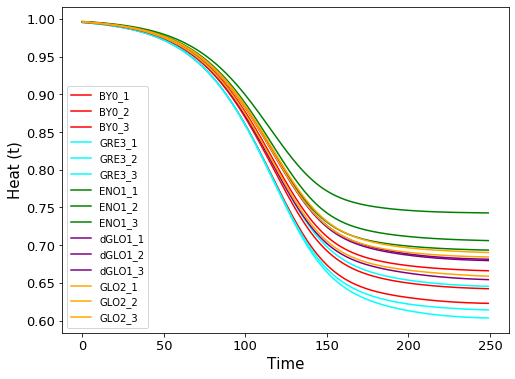

In [60]:
f, ax = plt.subplots(figsize=(8,6))
    
for i in TF_heat:
    if i.startswith('BY'):
        plt.plot(TF_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(TF_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(TF_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(TF_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(TF_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(TF_heat.keys())
plt.show()


In [61]:
heat_MN = pd.DataFrame(index=MN_heat.keys(), columns=MN_heat.keys())

for g in MN_heat:
    for i in MN_heat:
        heat_MN.loc[g,i] = nl.compare(MN_heat[g], MN_heat[i])

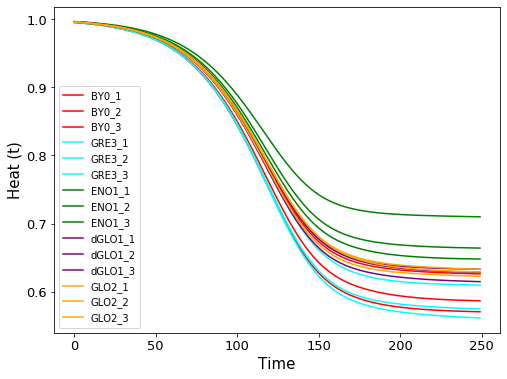

In [62]:
f, ax = plt.subplots(figsize=(8,6))
    
for i in MN_heat:
    if i.startswith('BY'):
        plt.plot(MN_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(MN_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(MN_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(MN_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(MN_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(MN_heat.keys())
plt.show()


### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets) - (Needs verification)

#### Explanation in Formula_Networks


In [63]:
TF_CorrMat = {}
for i in TF:
    #For 1 network
    orbits_t = calculating_orbits(TF[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    TF_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [64]:
TF_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in TF_CorrMat:
    samp_col = {}
    for u in range(len(TF_CorrMat[i])):
        for v in range(u+1, len(TF_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_CorrMat[i][u,v]
        TF_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_TF = pd.DataFrame.from_dict(TF_CorrMat_df)
#corrMat_TF

In [65]:
MN_CorrMat = {}
for i in MN:
    #For 1 network
    orbits_t = calculating_orbits(MN[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    MN_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [66]:
MN_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in MN_CorrMat:
    samp_col = {}
    for u in range(len(MN_CorrMat[i])):
        for v in range(u+1, len(MN_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_CorrMat[i][u,v]
        MN_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_MN = pd.DataFrame.from_dict(MN_CorrMat_df)
corrMat_MN

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
0-1,0.893740,0.900941,0.904380,0.927035,0.913098,0.921561,0.855534,0.900681,0.887226,0.903314,0.894953,0.907983,0.906664,0.896629,0.891468
0-2,0.841828,0.855751,0.868208,0.868099,0.875261,0.876967,0.775656,0.829641,0.814079,0.847396,0.844684,0.868741,0.843317,0.833173,0.841187
0-4,0.816608,0.839882,0.839768,0.865271,0.852775,0.866281,0.750006,0.794922,0.814793,0.843209,0.812679,0.845267,0.846225,0.815653,0.791803
0-5,0.805915,0.818563,0.836289,0.841022,0.845088,0.847506,0.744353,0.795091,0.786343,0.817539,0.812884,0.832103,0.821002,0.804113,0.808650
0-6,0.763053,0.756485,0.750487,0.817345,0.820688,0.828513,0.695809,0.737054,0.751408,0.786146,0.788485,0.783805,0.772050,0.754483,0.763157
0-7,0.641068,0.655474,0.648804,0.694270,0.704787,0.711118,0.580249,0.608681,0.630460,0.666281,0.672709,0.676967,0.647075,0.636686,0.649890
0-8,0.702954,0.676790,0.681079,0.759908,0.759557,0.748018,0.588265,0.630291,0.632972,0.710388,0.696106,0.742592,0.693233,0.701718,0.698404
0-9,0.691391,0.684286,0.677609,0.738495,0.763691,0.766879,0.631828,0.668184,0.664940,0.738863,0.739489,0.738110,0.683852,0.690432,0.695563
0-10,0.727740,0.716901,0.732807,0.746149,0.761290,0.773078,0.644751,0.674862,0.682265,0.743676,0.745977,0.762255,0.709604,0.702323,0.725688
0-11,0.678918,0.671507,0.685194,0.692604,0.723452,0.734489,0.584455,0.614167,0.626486,0.704609,0.700788,0.729429,0.662829,0.662638,0.674214


### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

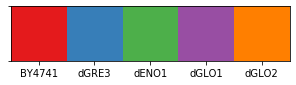

In [67]:
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split()

mtl.add_labels(degree_TF, labels = labels)
mtl.add_labels(betw_TF, labels = labels)
mtl.add_labels(closeness_TF, labels = labels)
mtl.add_labels(groups_TF, labels = labels)
mtl.add_labels(heat_TF, labels = labels)
mtl.add_labels(corrMat_TF, labels = labels)

mtl.add_labels(degree_MN, labels = labels)
mtl.add_labels(betw_MN, labels = labels)
mtl.add_labels(closeness_MN, labels = labels)
mtl.add_labels(groups_MN, labels = labels)
mtl.add_labels(heat_MN, labels = labels)
mtl.add_labels(corrMat_MN, labels = labels)

sample_names = degree_TF.cdl.samples
all_labels = degree_TF.cdl.labels
unique_labels = degree_TF.cdl.unique_labels

# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

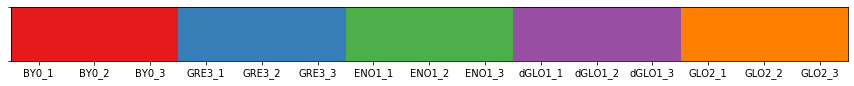

In [68]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Statistical Analysis and Discrimination of all sample Networks made

### Hierarchical Cluster Analysis (agglomerative)

HCA analysis and plotting 7 dendrograms based on the 6 dataframes built - degree, betweenness centrality, closeness centrality, sum of the 3 prior distance matrices, group influence and heat diffusion (already a distance matrix in this case, the distance matrix is used since no better option is available).

In [69]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(14,7))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=12, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### NetTF - Transformation List

Centrality measures Dendrograms

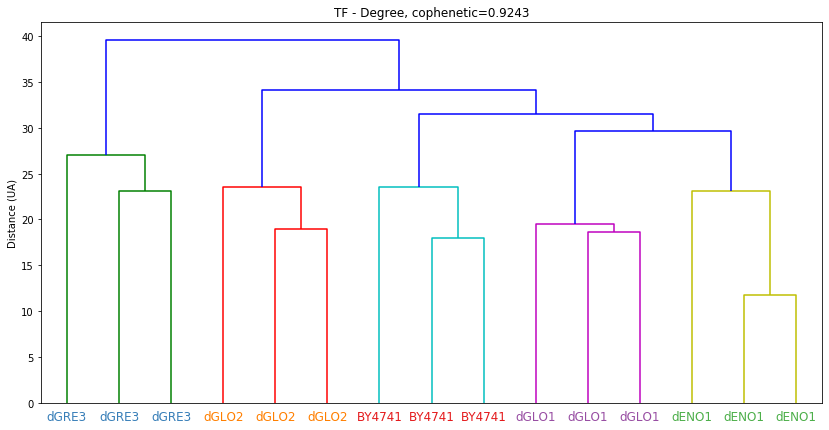

In [70]:
degree_df_jdist = dist.pdist(degree_TF.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z = hier.linkage(degree_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, degree_df_jdist)[0]

title = f'TF - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

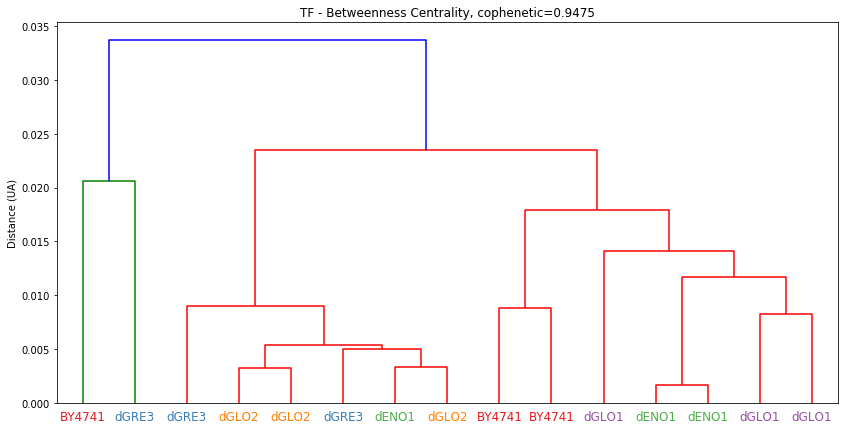

In [71]:
betw_df_jdist = dist.pdist(betw_TF.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z = hier.linkage(betw_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, betw_df_jdist)[0]

title = f'TF - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

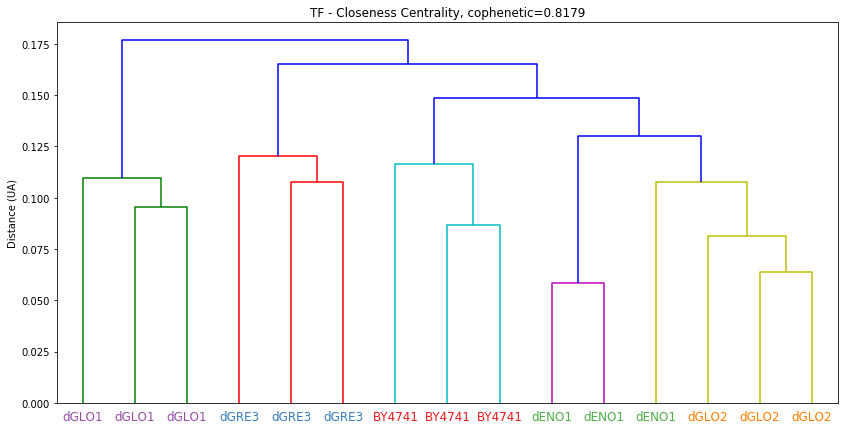

In [72]:
closeness_df_jdist = dist.pdist(closeness_TF.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z = hier.linkage(closeness_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, closeness_df_jdist)[0]

title = f'TF - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Group Influence Dendrogram

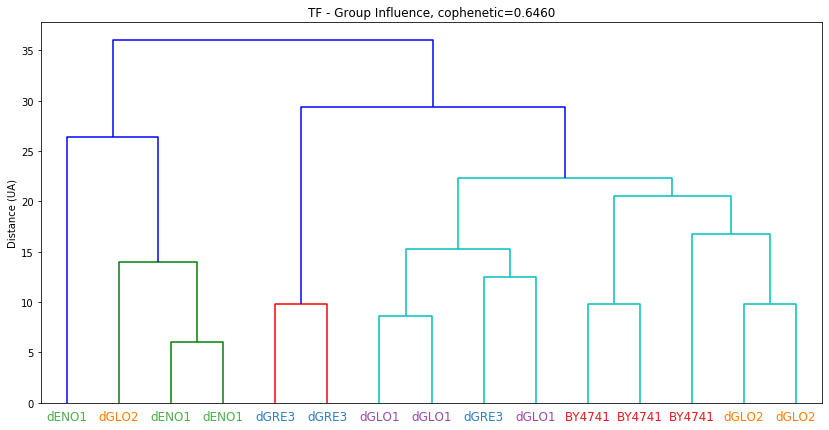

In [73]:
groups_df_dist = dist.pdist(groups_TF.T, metric='euclidean')
Z = hier.linkage(groups_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, groups_df_dist)[0] #method average seems to lead to higher coefficients

title = f'TF - Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Heat Diffusion Dendrogram

In [74]:
heat_df_short = dist.squareform(heat_TF) #Condensing the distance matrix
#Be careful when running these 3 cells, running them weirdly can lead to kernel dying for unknown reasons.

In [75]:
Z = hier.linkage(heat_df_short, method='average')

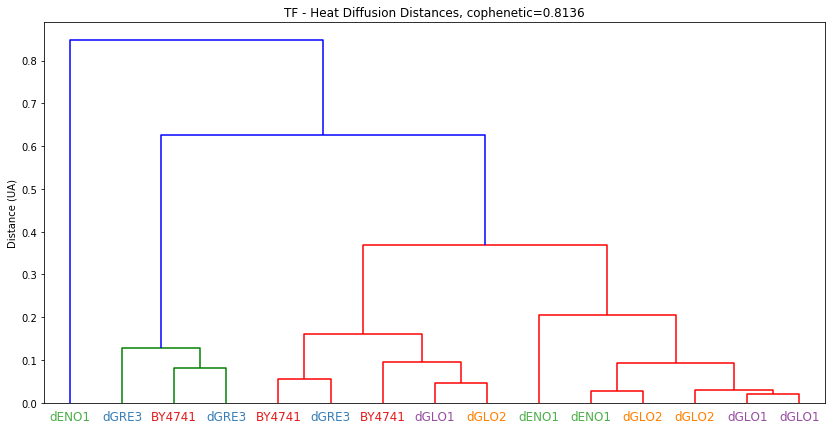

In [76]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, heat_df_short)[0] #method average seems to lead to higher coefficients

title = f'TF - Heat Diffusion Distances, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

GCD-11 Dendrogram

In [77]:
#Calculating distances between samples

#Both ways are equal - 2nd you get the condensed distance matrix right away

#1st way
#corrMat_df_dist = pd.DataFrame(index=G_CorrMat.keys(), columns=G_CorrMat.keys())

#for g in G_CorrMat:
#    for i in G_CorrMat:
#        corrMat_df_dist.loc[g,i] = np.linalg.norm(G_CorrMat[g]-G_CorrMat[i])
#corrMat_df_dist

#2nd way
corrMat_df_dist = dist.pdist(corrMat_TF.T)

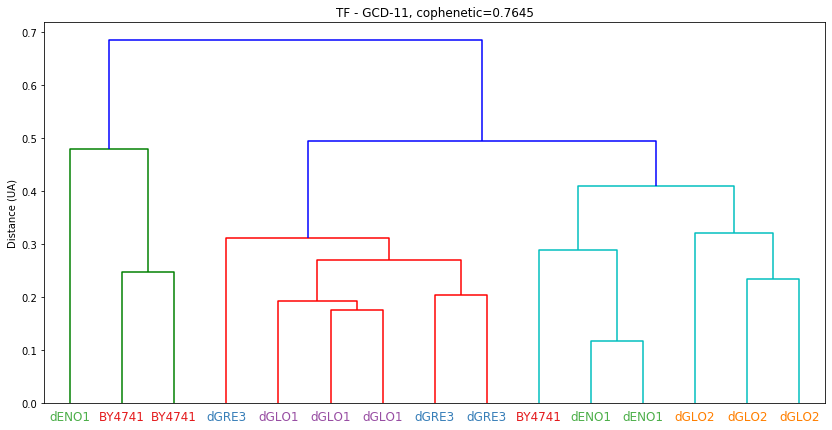

In [78]:
Z = hier.linkage(corrMat_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, corrMat_df_dist)[0] #method average seems to lead to higher coefficients

title = f'TF - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

### NetMN - MetaNetter

Centrality measures Dendrograms

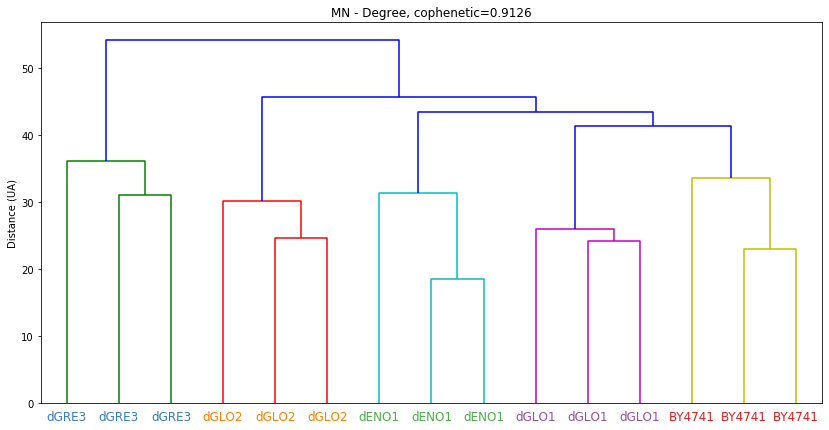

In [79]:
degree_df_jdist = dist.pdist(degree_MN.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z = hier.linkage(degree_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, degree_df_jdist)[0]

title = f'MN - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

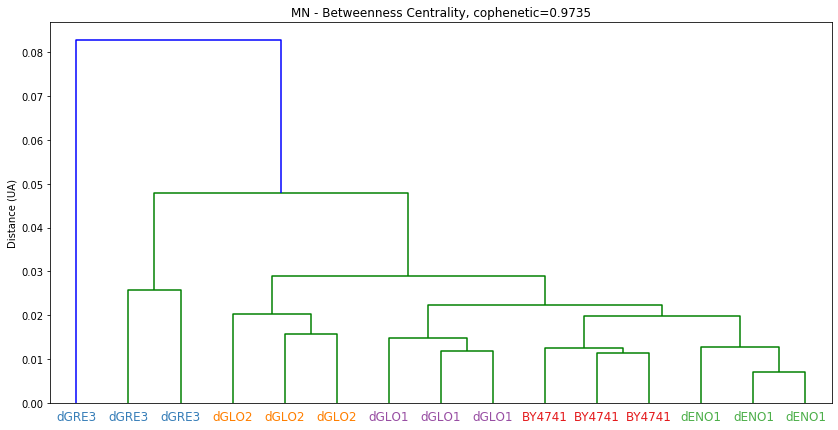

In [80]:
betw_df_jdist = dist.pdist(betw_MN.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z = hier.linkage(betw_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, betw_df_jdist)[0]

title = f'MN - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

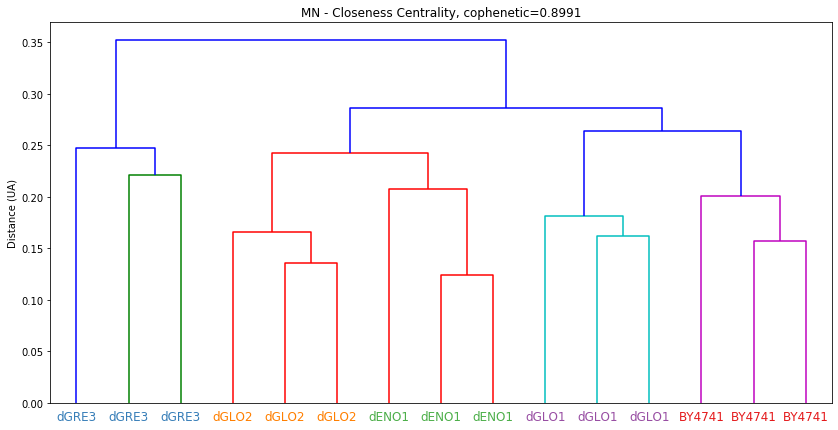

In [81]:
closeness_df_jdist = dist.pdist(closeness_MN.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z = hier.linkage(closeness_df_jdist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, closeness_df_jdist)[0]

title = f'MN - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Group Influence Dendrogram

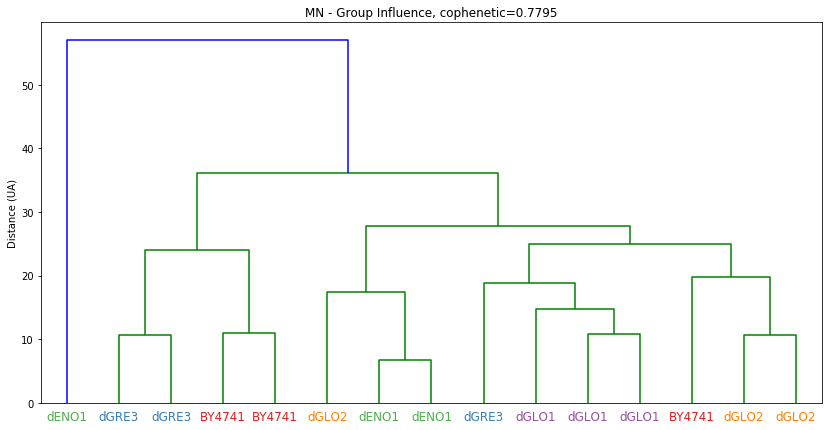

In [82]:
groups_df_dist = dist.pdist(groups_MN.T, metric='euclidean')
Z = hier.linkage(groups_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, groups_df_dist)[0] #method average seems to lead to higher coefficients

title = f'MN - Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Heat Diffusion Dendrogram

In [83]:
heat_df_short = dist.squareform(heat_MN) #Condensing the distance matrix
#Be careful when running these 3 cells, running them weirdly can lead to kernel dying for unknown reasons.

In [84]:
Z = hier.linkage(heat_df_short, method='average')

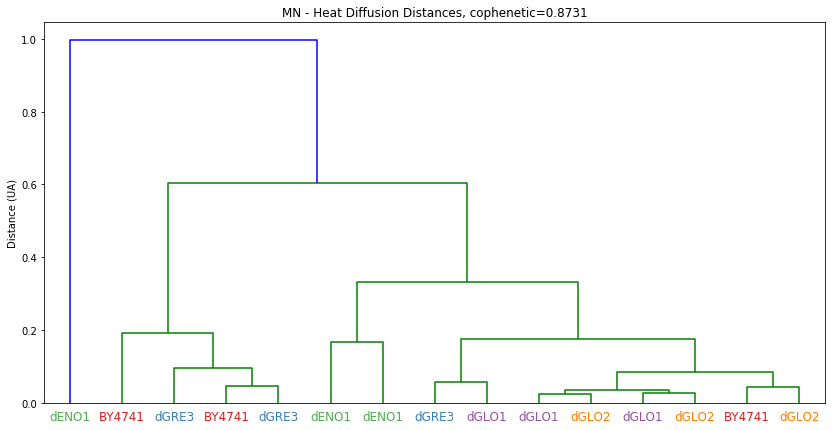

In [85]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, heat_df_short)[0] #method average seems to lead to higher coefficients

title = f'MN - Heat Diffusion Distances, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

GCD-11 Dendrogram

In [86]:
corrMat_df_dist = dist.pdist(corrMat_MN.T)

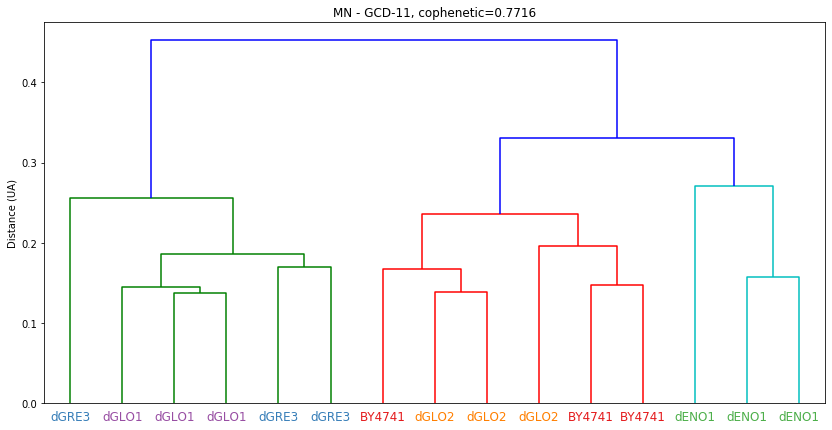

In [87]:
Z = hier.linkage(corrMat_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, corrMat_df_dist)[0] #method average seems to lead to higher coefficients

title = f'MN - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

## Supervised analysis

The datasets that will be analyzed:

In [88]:
datasets = {'TF_degree': degree_TF, 'TF_betweenness': betw_TF, 'TF_closeness' : closeness_TF, 'TF_groups': groups_TF,
           'TF_heat_dif': heat_TF, 'TF_GCD-11': corrMat_TF,
           'MN_degree': degree_MN, 'MN_betweenness': betw_MN, 'MN_closeness' : closeness_MN, 'MN_groups': groups_MN, 
           'MN_heat_dif': heat_MN, 'MN_GCD-11': corrMat_MN}

### Random Forests

Application of the Random Forests

In [89]:
# Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)
    #, iter_num = 100) #(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for TF_degree ...done
Fitting random forest for TF_betweenness ...done
Fitting random forest for TF_closeness ...done
Fitting random forest for TF_groups ...done
Fitting random forest for TF_heat_dif ...done
Fitting random forest for TF_GCD-11 ...done
Fitting random forest for MN_degree ...done
Fitting random forest for MN_betweenness ...done
Fitting random forest for MN_closeness ...done
Fitting random forest for MN_groups ...done
Fitting random forest for MN_heat_dif ...done
Fitting random forest for MN_GCD-11 ...done


Performance of each predictive model

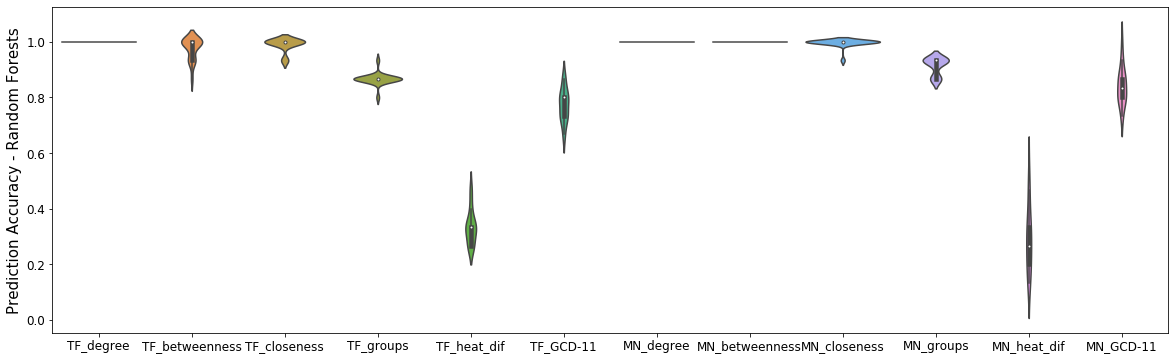

In [90]:
f, ax = plt.subplots(figsize=(20,6))
data = pd.DataFrame.from_dict(Scores)
sns.violinplot(data = data,  alpha = 0.5) #palette = colors*2,
plt.ylabel('Prediction Accuracy - Random Forests', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)

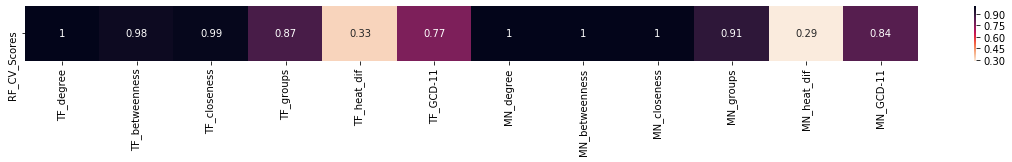

In [91]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [92]:
Imp_feat['TF_groups'] #Important groups whose influence can be characteristic of each network

[(10, 0.11150698820056039, 'PO3H'),
 (5, 0.08353448581292199, 'NCH'),
 (13, 0.07820195625112061, 'CO'),
 (11, 0.07707949367540524, 'NH3(-O)'),
 (1, 0.07616212693238356, 'CH2'),
 (0, 0.07593841255400098, 'H2'),
 (3, 0.06786211336052665, 'O'),
 (14, 0.06262347008407486, 'C2H2O'),
 (15, 0.056351848968621505, 'H2O'),
 (8, 0.053757373513253846, 'S'),
 (7, 0.05199610767370284, 'OH'),
 (9, 0.048529437414478925, 'CONH'),
 (12, 0.048220676796024514, 'SO3'),
 (6, 0.04772565296488969, 'O(-NH)'),
 (2, 0.04387783462968255, 'CO2'),
 (4, 0.016632021168351965, 'CHOH')]

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

All analysis is similar to the ones performed in similarity_analysis notebooks.

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [93]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


#### Search for the best number of components to use

In [94]:
%%capture --no-stdout
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 7)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for TF_degree ...done
Optimizing PLS-DA for TF_betweenness ...done
Optimizing PLS-DA for TF_closeness ...done
Optimizing PLS-DA for TF_groups ...done
Optimizing PLS-DA for TF_heat_dif ...done
Optimizing PLS-DA for TF_GCD-11 ...done
Optimizing PLS-DA for MN_degree ...done
Optimizing PLS-DA for MN_betweenness ...done
Optimizing PLS-DA for MN_closeness ...done
Optimizing PLS-DA for MN_groups ...done
Optimizing PLS-DA for MN_heat_dif ...done
Optimizing PLS-DA for MN_GCD-11 ...done


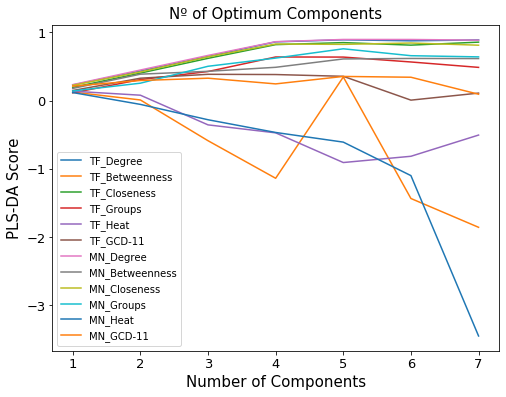

In [95]:
f, ax = plt.subplots(figsize=(8,6))


for name, data in PLS_optim.items():
    plt.plot(range(1,8),data)
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(('TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_Groups', 'TF_Heat', 'TF_GCD-11',
           'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_Groups', 'MN_Heat', 'MN_GCD-11'))
plt.show()

#### Application of PLS-DA

In [96]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [97]:
%%capture --no-stdout

for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for TF_degree ...done
Fitting PLS-DA for TF_betweenness ...done
Fitting PLS-DA for TF_closeness ...done
Fitting PLS-DA for TF_groups ...done
Fitting PLS-DA for TF_heat_dif ...done
Fitting PLS-DA for TF_GCD-11 ...done
Fitting PLS-DA for MN_degree ...done
Fitting PLS-DA for MN_betweenness ...done
Fitting PLS-DA for MN_closeness ...done
Fitting PLS-DA for MN_groups ...done
Fitting PLS-DA for MN_heat_dif ...done
Fitting PLS-DA for MN_GCD-11 ...done


Accuracy based on the dataset


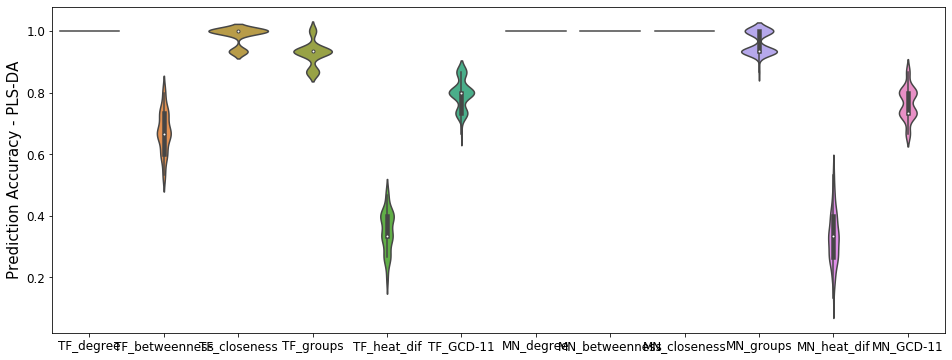

In [98]:
f, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), alpha = 0.5)#palette = colors, 
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 12)
print('Accuracy based on the dataset')

In [99]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

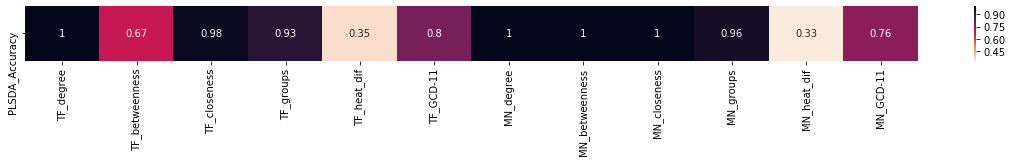

In [100]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [101]:
PLS_feat['TF_groups'] #s and CONH still useless. The main contriuting groups are different from the ones in Random Forests.

[(14, 0.16728769741737448, 'C2H2O'),
 (5, 0.13056318135945813, 'NCH'),
 (3, 0.12716089864576666, 'O'),
 (0, 0.1222051518824681, 'H2'),
 (13, 0.11975514770935161, 'CO'),
 (1, 0.11406888644930263, 'CH2'),
 (10, 0.10340537968735873, 'PO3H'),
 (2, 0.0930846422401426, 'CO2'),
 (8, 0.0922408896755483, 'S'),
 (11, 0.08650451137605873, 'NH3(-O)'),
 (7, 0.08595447049308232, 'OH'),
 (9, 0.08357710730025952, 'CONH'),
 (15, 0.06615684702811161, 'H2O'),
 (12, 0.05961019041745895, 'SO3'),
 (6, 0.04609609941735122, 'O(-NH)'),
 (4, 0.042269163281514525, 'CHOH')]

## Conclusions

- Results are very similar using these MDiN's constructed with MetaNetter to the networks made with the assigned formulas despite the higher edge counts from the MetaNetter.
- Results are very similar to what was obtained in the original Formula_Networks - Centrality measures make an almost perfect discrimination while topology centered methods and group influences have slightly worse performances.
- This, in one hand, means that the original approach was fine and that the conclusions won't change a lot between the two.
- In the other hand, it first means I'll have to edit a lot of the text I wrote for the thesis about the "Formula-Differences Network".
- It also means that for this kind of analysis, no formula assignment is needed since in this way, no formulas is actually needed for analysis. Possible drawback is not accounting for really weird formulas that can exist for continuous adding of certain groups without looking at ratios between elements but since we want to look at an estimation of the chemcial diversity of the sample represented by the topology of a network, this probably isn't a major drawback.
- Finally, no necessary formula assignment makes it possible to analyze the Grapevine dataset also in this way.


### Permutation Tests - PLS-DA

In [102]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (degree_TF, betw_TF, closeness_TF, groups_TF, heat_TF, corrMat_TF,
           degree_MN, betw_MN, closeness_MN, groups_MN, heat_MN, corrMat_MN,)
names = ('TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_Groups', 'TF_Heat', 'TF_GCD-11',
           'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_Groups', 'MN_Heat', 'MN_GCD-11')
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for TF_Degree ...
Done!
permutation test (PLS-DA) for TF_Betweenness ...
Done!
permutation test (PLS-DA) for TF_Closeness ...
Done!
permutation test (PLS-DA) for TF_Groups ...
Done!
permutation test (PLS-DA) for TF_Heat ...
Done!
permutation test (PLS-DA) for TF_GCD-11 ...
Done!
permutation test (PLS-DA) for MN_Degree ...
Done!
permutation test (PLS-DA) for MN_Betweenness ...
Done!
permutation test (PLS-DA) for MN_Closeness ...
Done!
permutation test (PLS-DA) for MN_Groups ...
Done!
permutation test (PLS-DA) for MN_Heat ...
Done!
permutation test (PLS-DA) for MN_GCD-11 ...
Done!


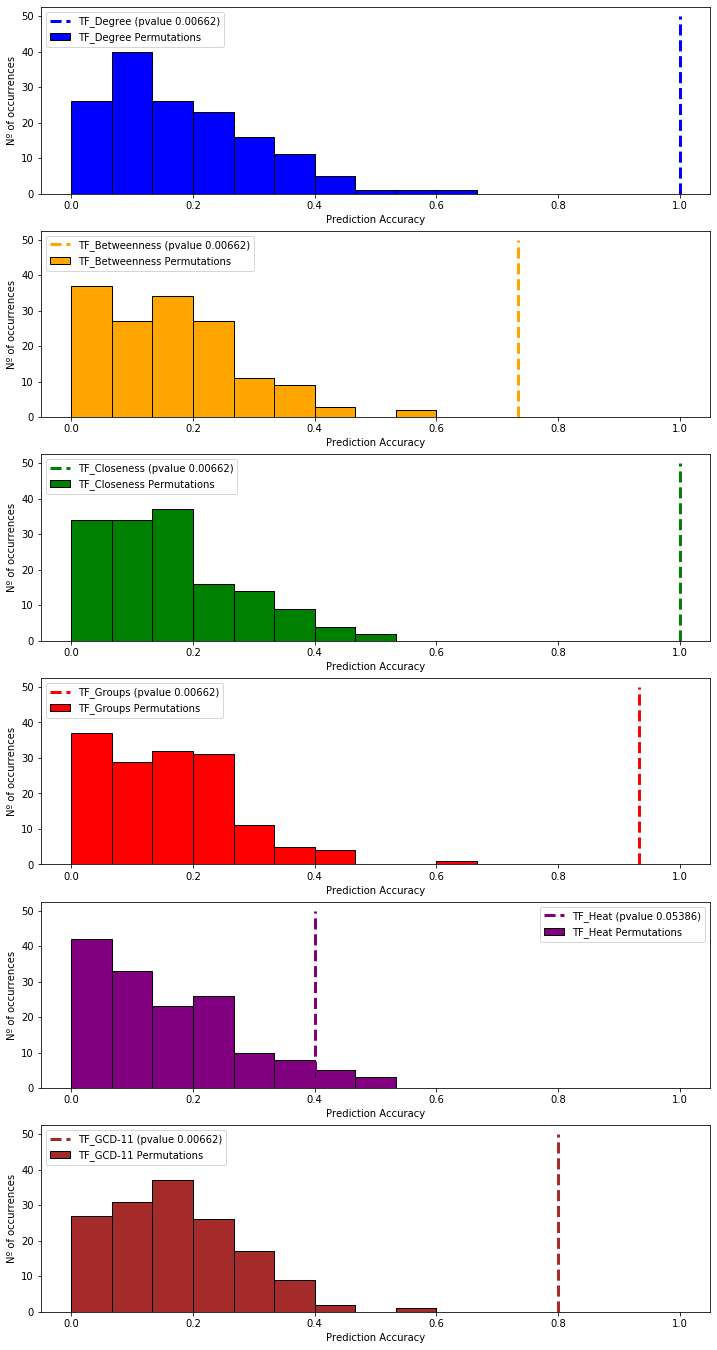

In [103]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_Groups', 'TF_Heat', 'TF_GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

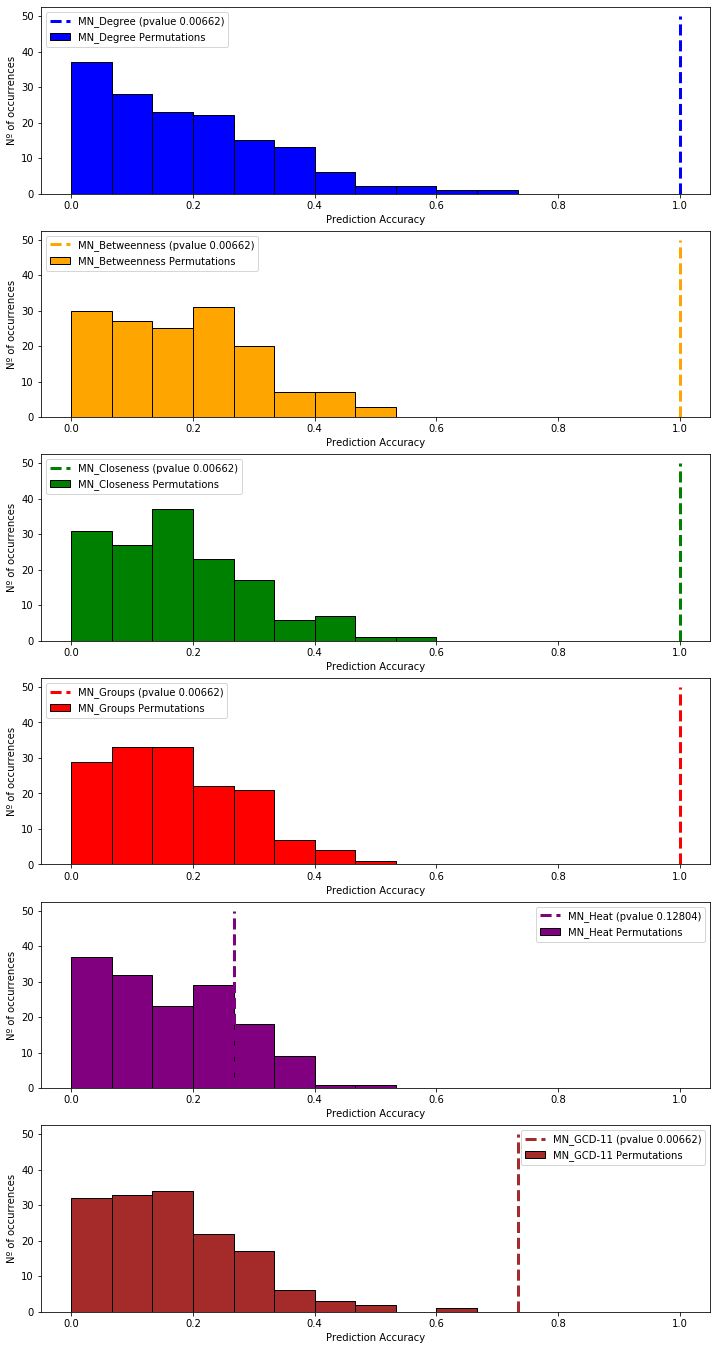

In [104]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_Groups', 'MN_Heat', 'MN_GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - Random Forests

In [105]:
CV = {}
PMs = {}
pvalue = {}

all_data = (degree_TF, betw_TF, closeness_TF, groups_TF, heat_TF, corrMat_TF,
           degree_MN, betw_MN, closeness_MN, groups_MN, heat_MN, corrMat_MN,)
names = ('TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_Groups', 'TF_Heat', 'TF_GCD-11',
           'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_Groups', 'MN_Heat', 'MN_GCD-11')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for TF_Degree ...
Done!
Permutation test (Random Forest) for TF_Betweenness ...
Done!
Permutation test (Random Forest) for TF_Closeness ...
Done!
Permutation test (Random Forest) for TF_Groups ...
Done!
Permutation test (Random Forest) for TF_Heat ...
Done!
Permutation test (Random Forest) for TF_GCD-11 ...
Done!
Permutation test (Random Forest) for MN_Degree ...
Done!
Permutation test (Random Forest) for MN_Betweenness ...
Done!
Permutation test (Random Forest) for MN_Closeness ...
Done!
Permutation test (Random Forest) for MN_Groups ...
Done!
Permutation test (Random Forest) for MN_Heat ...
Done!
Permutation test (Random Forest) for MN_GCD-11 ...
Done!


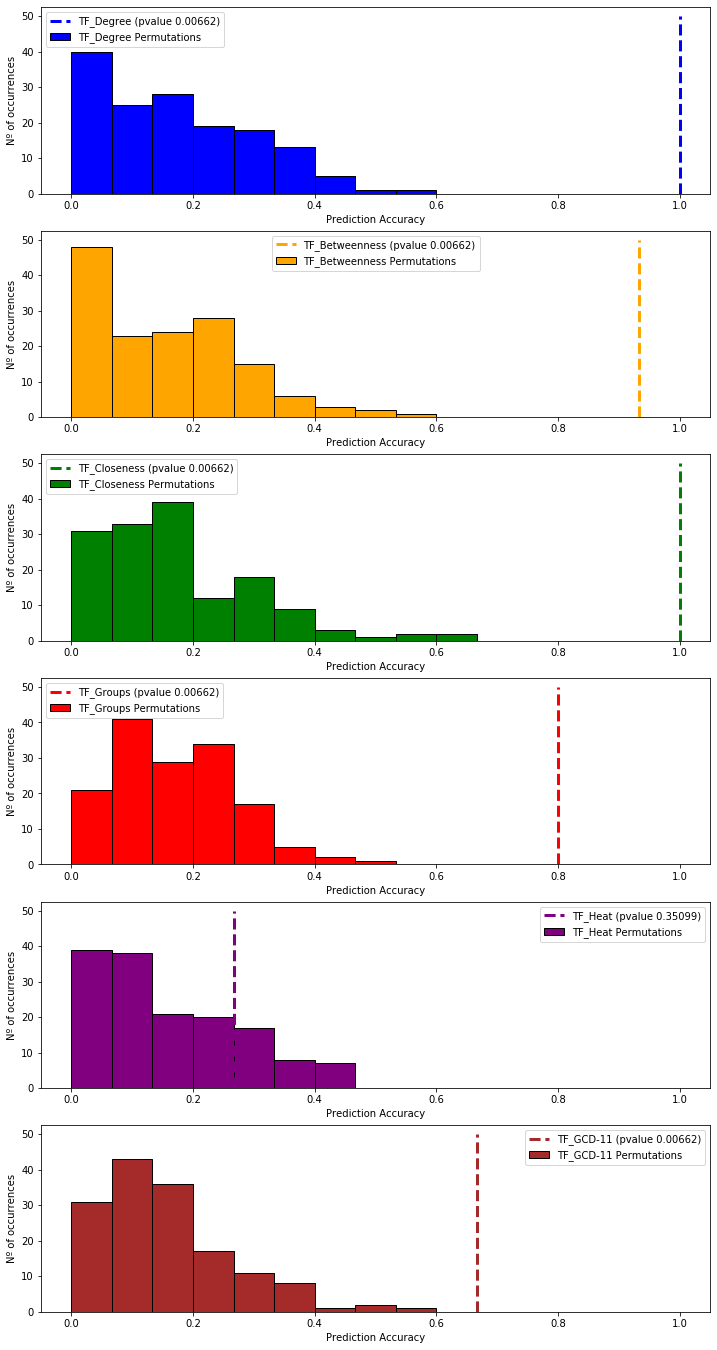

In [106]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_Groups', 'TF_Heat', 'TF_GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

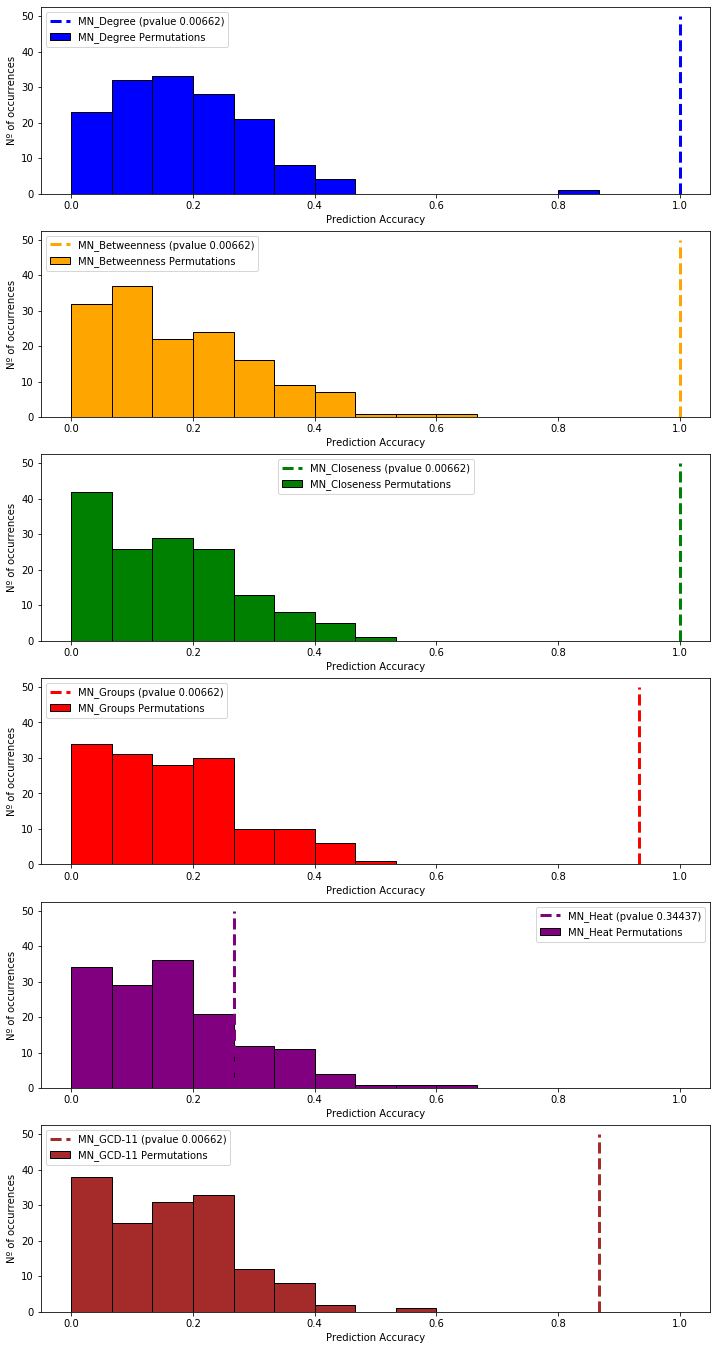

In [107]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_Groups', 'MN_Heat', 'MN_GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Stuff to see if sample network from scratch and from induced subgraph was isomorphic

In [ ]:
for j in yeast_df.columns[3:]:
    df = yeast_df[yeast_df.loc[:,j] != 0] #Selecting the formulas that actually appear in each sample
    title = 'Net_' + str(j) + '.csv'
    pd.DataFrame(df.index, columns=['Nodes'], index=df.index).to_csv(title)
    #formula_df.index = df['Formula'] #Using the 'string' formulas as indexes
df

In [370]:
BY01 = nx.read_graphml('Net_BY0_1-TF.graphml').to_undirected()
len(BY01.nodes())

673

In [383]:
nx.get_node_attributes(BY01,'mass')
new_nodes = dict.fromkeys(BY01.nodes(),0)
formula_attr = dict.fromkeys(BY01.nodes(),0)
intensity_attr = dict.fromkeys(BY01.nodes(),0)
for i,j in nx.get_node_attributes(BY01,'mass').items():
    #print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    intensity_attr[i] = {'intensity':yeast_df.loc[j,'BY0_1']}
    new_nodes[i] = j
nx.set_node_attributes(BY01,intensity_attr)
BY01 = nx.relabel_nodes(BY01, mapping=new_nodes)
#BY01.nodes()[743.4413052682]

{'SUID': 14523,
 'shared name': '743,4413',
 'name': '743,4413',
 'selected': False,
 'mass': 743.4413052682,
 'Nodes': 743.4413052682,
 'formula': nan,
 'intensity': 596857.875}

In [372]:
BY01_ot = dde.subgraph(yeast_df[yeast_df.iloc[:,3] != 0].index)
#BY01_ot = dde.subgraph(yeast_df.iloc[:,3] != 0)
len(BY01_ot)

673

In [373]:
#Group Influence in building the network
BY2_groups = dict.fromkeys(groups, 0)
for i in BY01.edges():
    #print(i)
    BY2_groups[BY01.edges()[i]['Transformation']] = BY2_groups[BY01.edges()[i]['Transformation']] + 1
BY2_groups

{'H2': 33,
 'CH2': 66,
 'CO2': 16,
 'O': 37,
 'CHOH': 0,
 'NCH': 11,
 'O(-NH)': 11,
 'OH': 1,
 'S': 4,
 'CONH': 6,
 'PO3H': 19,
 'NH3(-O)': 11,
 'SO3': 1,
 'CO': 29,
 'C2H2O': 13,
 'H2O': 31}

In [374]:
#Group Influence in building the network
BY2_groups = dict.fromkeys(groups, 0)
for i in BY01_ot.edges():
    #print(i)
    BY2_groups[BY01_ot.edges()[i]['Transformation']] = BY2_groups[BY01_ot.edges()[i]['Transformation']] + 1
BY2_groups

{'H2': 33,
 'CH2': 66,
 'CO2': 16,
 'O': 37,
 'CHOH': 0,
 'NCH': 11,
 'O(-NH)': 11,
 'OH': 1,
 'S': 4,
 'CONH': 6,
 'PO3H': 19,
 'NH3(-O)': 11,
 'SO3': 1,
 'CO': 29,
 'C2H2O': 13,
 'H2O': 31}

In [375]:
[len(c) for c in sorted(nx.connected_components(BY01), key=len, reverse=True)][:20]

[96, 23, 10, 9, 7, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]

In [376]:
[len(c) for c in sorted(nx.connected_components(BY01_ot), key=len, reverse=True)][:20]

[96, 23, 10, 9, 7, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]

In [377]:
nx.is_isomorphic(BY01,BY01_ot)

True